In [ ]:
# Imports for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install fastcluster

In [ ]:
# Imports for model training, tuning and evaluation
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, roc_curve, f1_score, confusion_matrix, classification_report

# T1.1: Exploratory Data Analysis
Explore the data to generate summary statistics and plots that help the reader understand the data, with a focus on information relevant to the classification task.

In [ ]:
data = pd.read_csv("data1.csv.gz", compression="gzip")
data.head()

,label,DPM1,NIPAL3,KRIT1,LAP3,CD99,MAD1L1,LASP1,M6PR,CFLAR,...,CISD3,DDX52,GGNBP2,C11orf98,MRPL45,TRG.AS1,EBLN3P,TRBV7.2,AC010642.2,POLR2J3.1
0,TREG,0.000000,0.0,0.0,0.0,4.459588,0.000000,4.175754,3.107406,3.107406,...,0.000000,0.000000,0.000000,3.777941,0.000000,0.000000,0.000000,0.000000,3.107406,0.000000
1,TREG,0.000000,0.0,0.0,0.0,3.159469,3.159469,0.000000,0.000000,3.159469,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.484917,0.000000,0.000000
2,CD4+T,3.568377,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.568377,0.000000,0.000000,0.000000,0.000000
3,CD4+T,2.574454,0.0,0.0,0.0,3.228759,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.574454,0.000000,0.000000,2.574454,0.000000,2.574454,0.000000,0.000000,2.574454
4,CD4+T,0.000000,0.0,0.0,0.0,0.000000,3.418392,0.000000,0.000000,0.000000,...,2.757484,0.000000,3.418392,0.000000,0.000000,2.757484,3.418392,0.000000,0.000000,0.000000


In [ ]:
# Preliminary summary statistics for features
print("Shape of the dataset: ", data.shape)
print(data["label"].value_counts())
print("\nSummary Statistics:\n", data.describe())

Shape of the dataset:  (5471, 4124)
label
CD4+T    3356
TREG     2115
Name: count, dtype: int64

Summary Statistics:
               DPM1       NIPAL3        KRIT1         LAP3         CD99  \
count  5471.000000  5471.000000  5471.000000  5471.000000  5471.000000   
mean      0.632655     0.503041     0.451158     0.871690     2.138707   
std       1.195156     1.099875     1.046742     1.356735     1.683733   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     2.833816   
75%       0.000000     0.000000     0.000000     2.328390     3.506334   
max       4.568712     4.581066     4.574394     5.012749     5.909840   

            MAD1L1        LASP1         M6PR        CFLAR         RBM5  ...  \
count  5471.000000  5471.000000  5471.000000  5471.000000  5471.000000  ...   
mean      1.360206     0.839459     1.603090     0.746686

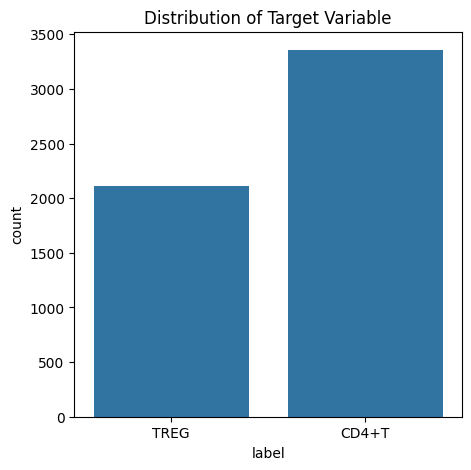

In [ ]:
# Visualising the balance of classes
fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(x=data["label"], data=data)
plt.title("Distribution of Target Variable")
plt.show()

### EDA 1: Standardised gene expression variability
**Rationale:** By computing the variation in the magnitude of gene expressions across both classes (column-wise variance), we might be able to identify some genes that have high variation because they display larger magnitudes of expression pertaining to one cell type instead of another - useful for classification.

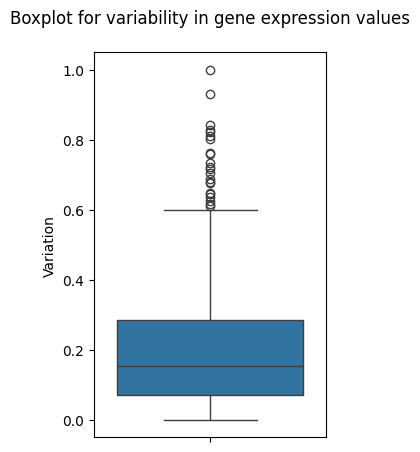


Summary statistics for the variability of the gene expressions across both classes:



,0
count,4123.000000
mean,0.180204
std,0.130207
min,0.000000
25%,0.069117
50%,0.152154
75%,0.283351
max,1.000000


In [ ]:
# Compute the variance for the gene expression levels across both classes
variability_genes = data.iloc[:, 1:].var(axis=0)
variability_genes = (variability_genes - variability_genes.min()) / (variability_genes.max() - variability_genes.min())
variability_genes = variability_genes.sort_values(ascending=False)

# Make the boxplot to
fig, ax = plt.subplots(figsize=(3,5))
sns.boxplot(data=variability_genes, ax=ax)
plt.title("Boxplot for variability in gene expression values\n")
plt.ylabel("Variation")
plt.show()

# Print the summary statistics corresponding to the boxplot
print("\nSummary statistics for the variability of the gene expressions across both classes:\n")
variability_genes.describe()

**Observations:**



1.   Upon scaling the variances we observe by plotting the summary statistics of gene variation across classes that the mean variation = 0.18, and median variation 0.15.
2.   We do not concern ourselves with the study of gene expressions with low variability: because these gene expressions are present with roughly similar magnitudes in both classes of cells.
3.   We care about highly variable gene expressions, because the more variable they are the more likely they are to contribute meaningfully to distinguishing between the two cell types. The majority of high-variability genes are concentrated in the top 25%, making them the most likely candidates for the analysis; reducing the number of variables (gene expressions) we focus on.
4.  **Significance:** Highly variable genes are likely to be more biologically significant in distinguishing cell types, as their variability indicates stronger differences in expression levels across cells.


### EDA 2: Selecting a subset of gene expressions to focus on
**Rationale:** To further reduce the number of gene expressions modelled from 25% of total gene expressions (approximately 1000) to a smaller quantity of variables for further analysis, we consider how much of the variance is captured by the top 20, 50, 100 models.
    

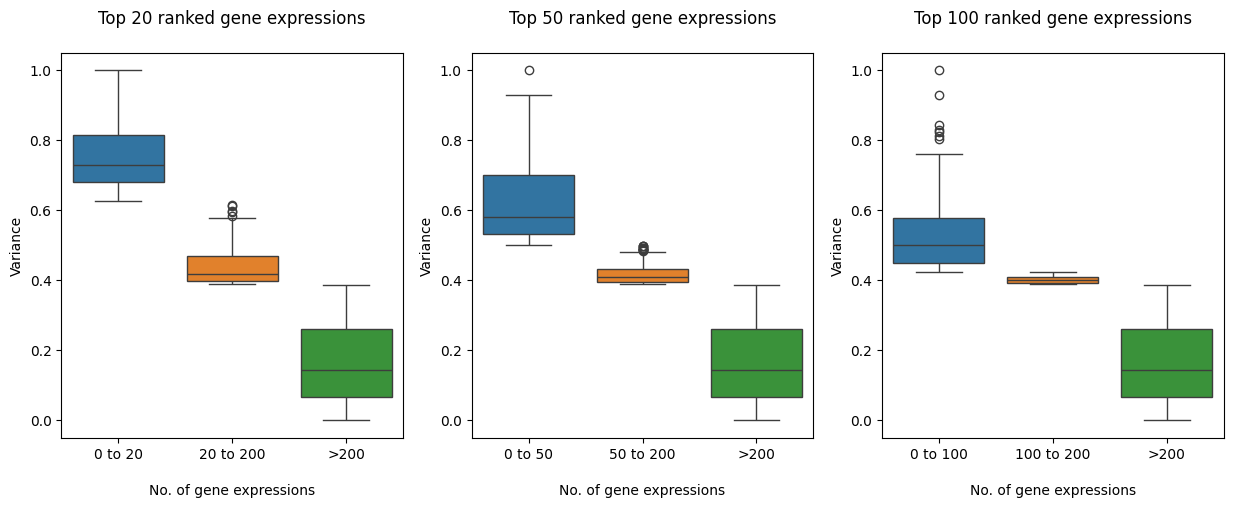

In [ ]:
# Define the top subset of gene expressions to focus on
model_sizes = [20, 50, 100]
labels = [["0 to 20", "20 to 200", ">200"], ["0 to 50", "50 to 200", ">200"],
          ["0 to 100", "100 to 200", ">200"]]

# Make the boxplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(0,3):
  size = model_sizes[i]
  variable_genes_concat = pd.concat([variability_genes[:size], variability_genes[size:200], variability_genes[200:]], keys=labels[i], axis=1)
  sns.boxplot(data=variable_genes_concat, ax=ax[i])
  ax[i].set_xticks([0, 1, 2])
  ax[i].set_xticklabels(labels[i])
  ax[i].set_title(f"Top {model_sizes[i]} ranked gene expressions\n")
  ax[i].set_ylabel("Variance")
  ax[i].set_xlabel("\nNo. of gene expressions")

plt.show()

**Observations:**


1.   We observe that the amount of variation captured by the top 50 models is way larger when compared to the variability accounted for by the 50 models added between 150 to 200 models.
2.   Therefore, when considering the trade-off between model complexity and the amount of knowledge on variation captured by the gene expressions, we conclude that adding up to the first 100 gene expressions to the model would be sufficient enough to capture the trends in the data to distinguish between the two cell types, while enabling a more parsimonious model.




### EDA 3: Visualising variances for specific example genes
We use violin plots to explore the variances for specific genes, showcasing two good and bad examples.

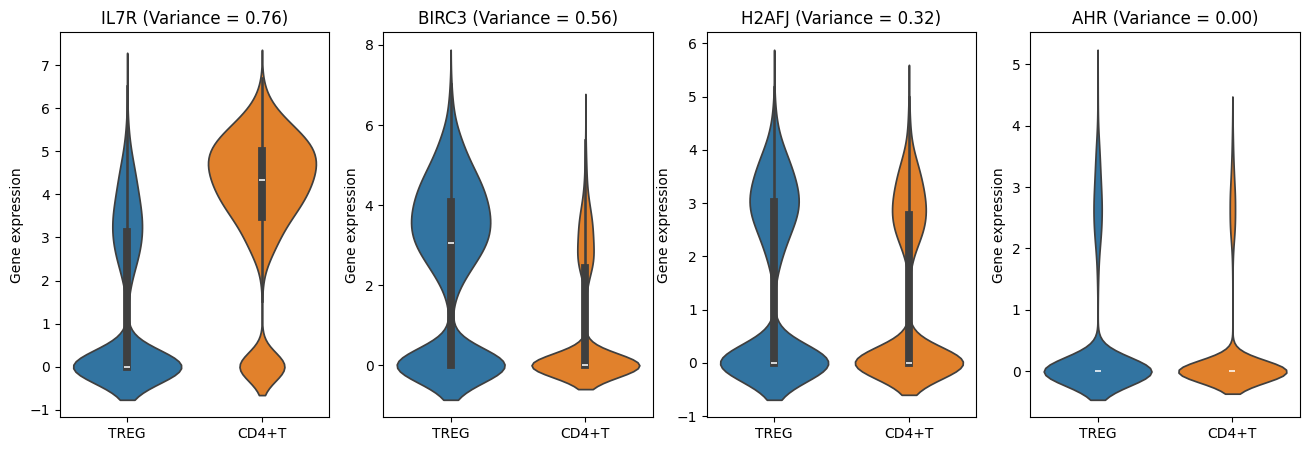

In [ ]:
# Create new datasets by splitting the original dataset based on cell type & select 4 diverse genes to display
treg_data = data[data["label"]=="TREG"].iloc[:,1:]
cd4_data = data[data["label"]=="CD4+T"].iloc[:,1:]
cell_labels = ["TREG", "CD4+T"]
example_genes = ["IL7R", "BIRC3", "H2AFJ", "AHR"]
example_genes_var = ["IL7R (Variance = 0.76)", "BIRC3 (Variance = 0.56)", "H2AFJ (Variance = 0.32)", "AHR (Variance = 0.00)"]

# Make the violin plots
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

for i in range(0,4):
  gene_label = example_genes[i]
  genes_cell_concat = pd.concat([treg_data[gene_label], cd4_data[gene_label]], keys=cell_labels, axis=1)
  sns.violinplot(data=genes_cell_concat, ax=ax[i])
  ax[i].set_xticks([0, 1])
  ax[i].set_xticklabels(cell_labels)
  ax[i].set_title(example_genes_var[i])
  ax[i].set_ylabel("Gene expression")

plt.show()

**Observations:** The above plots support our claim that larger variability in gene expressions may be a good indicator for variables being important classifiers:
*   IL7R (High variance = 0.76): For TREG cells, the distribution of IL7R is relatively narrow and concentrated around lower expression values, with the density decreasing sharply at higher values. On the contrary, the median is noticeably higher in CD4+T cells and distribution of the gene is concentrated at higher values. Therefore, IL7R could be a strong candidate for distinguising between these cell types, due to the gene being more predominantly expressed in CD4+T cells instead of TREG cells.
*   BIRC3 (Moderately high variance = 0.55): There still exists an observable distinction between the gene's expression in both cell types. At a higher median value of 4 and a concentrated density at large expression values, this gene is more characteristic of TREG cells instead of CD4+T cells, and thus could be a handy biologically distinguishing feature to use for modelling.
*   H2AFJ (Low variance = 0.32): When examining a low-variance gene, it becomes challenging to determine whether the gene has higher expressions in one of the two cell types. The medians for both violin plots are rather small between 0.5 to 1, and the distribution around higher expression values appears to be relatively narrow compared to the genes above, limiting our ability to discern meaningful differences between the expressions for the purpose of classification.
*   AHR (No variance = 0.0): We can observe that AHR's expressions are concentrated between 0.5 to 1, and the violin plots appear to be nearly identical for both genes with extremely tightly clustered data values for higher expression levels. This indicates that this individual gene has minimal to no predictive power for the classification task.



### EDA 4: Correlation heatmap for the top 30 most variable gene expressions

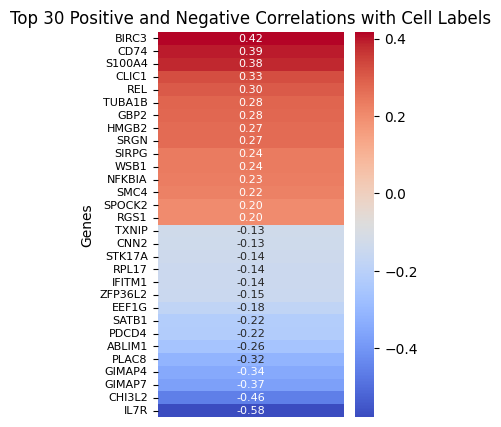

In [ ]:
# Compute the correlations and arrange them in descending order
data["binary_label"] = data["label"].map({"TREG": 1, "CD4+T": 0})
variability_genes_100 = variability_genes[:100]
correlations = data[variability_genes_100.index].corrwith(data["binary_label"]).sort_values(ascending=False)

# Get the top 15 positive and top 15 negative correlations
top_15_treg = correlations.head(15)
top_15_cd4 = correlations.tail(15)
selected_correlations = pd.concat([top_15_treg, top_15_cd4])

# Plot the heatmap
fig, ax = plt.subplots(figsize=(3, 5))

sns.heatmap(selected_correlations.to_frame(), cmap="coolwarm", annot=True, annot_kws={"fontsize": 8}, fmt=".2f", cbar=True, ax=ax)
plt.title("Top 30 Positive and Negative Correlations with Cell Labels")
plt.ylabel("Genes")
ax.set_yticks([i + 0.5 for i in range(len(selected_correlations))])
ax.set_yticklabels((selected_correlations.index), fontsize=8)
ax.set_xlabel("")
ax.set_xticks([])

plt.show()

### EDA 5: Correlations of the gene expression levels with the binary cell type

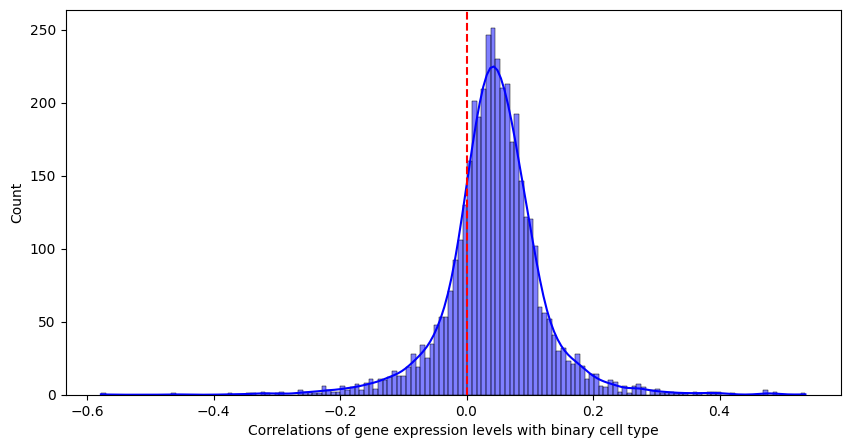

In [ ]:
# Overall correlations for all data points
all_genes = data.drop(["label", "binary_label"], axis=1)
all_correlations = all_genes.corrwith(data["binary_label"])

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(all_correlations, kde=True, color='blue', bins=150, ax=ax)
plt.xlabel("Correlations of gene expression levels with binary cell type")
plt.axvline(0, color='red', linestyle='--')
plt.show()

### EDA 6: Correlations between different genes
1. Correlation heatmap for gene expressions
2. Clustered heatmap for gene expressions

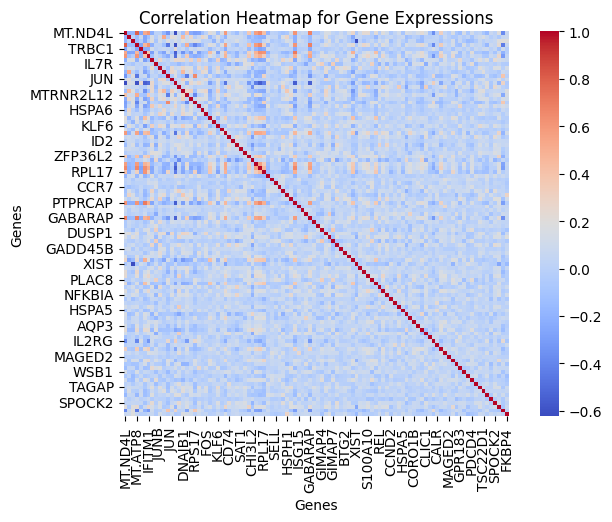

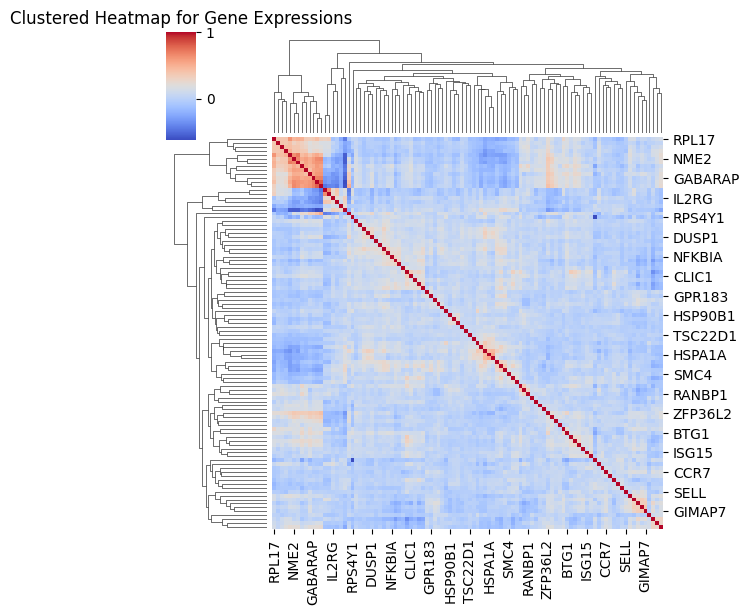

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

genes_data = data[variability_genes_100.index]
corr_matrix = genes_data.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, cbar=True, square=True)
plt.title("Correlation Heatmap for Gene Expressions")
plt.xlabel("Genes")
plt.ylabel("Genes")
plt.show()

# Clustered Heatmap with hierarchical clustering
sns.clustermap(corr_matrix, method="average", metric="euclidean", cmap="coolwarm", figsize=(6, 6), annot=False)
plt.title("Clustered Heatmap for Gene Expressions")
plt.show()

# T1.2: Training & Evaluating models

### Defining functions for model training and evaluation

In [ ]:
# Split into training and test sets
X = data.drop(["label", "binary_label"], axis=1)
y = data["binary_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA and reduce to 10 components
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Metrics function
def get_metrics(y_test, y_pred, y_proba, print_metrics=False):
  metrics = {
      "Accuracy": accuracy_score(y_test, y_pred),
      "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
      "F1 score": f1_score(y_test, y_pred),
      "AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
      "Confusion Matrix": confusion_matrix(y_test, y_pred),
      "Classification Report": classification_report(y_test, y_pred),
      "ROC Curve": roc_curve(y_test, y_proba) if y_pred is not None else None,
    }

  if print_metrics:
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print(f"Balanced Accuracy: {metrics['Balanced Accuracy']:.2f}")
    print(f"F1 Score: {metrics['F1 score']:.2f}")
    if metrics["AUC"] is not None:
      print(f"AUC: {metrics['AUC']:.2f}")
    else:
      print("AUC: Not applicable for this classifier")
    print("Classification Report:")
    print(metrics["Classification Report"])
    print("Confusion Matrix:")
    print(metrics["Confusion Matrix"])
    print("-" * 40)

  return metrics

# Train and evaluate classifiers function
def train_and_evaluate(name, classifier, X_train, X_test, y_train, y_test):
    # Train metrics
    classifier.fit(X_train, y_train)
    y_pred_train = classifier.predict(X_train)
    y_proba_train = classifier.predict_proba(X_train)[:, 1] if hasattr(classifier, "predict_proba") else None
    print(f"--- Train Metrics for {name} ---")
    train_metrics = get_metrics(y_train, y_pred_train, y_proba_train, print_metrics=True)

    # Test metrics
    y_pred_test = classifier.predict(X_test)
    y_proba_test = classifier.predict_proba(X_test)[:, 1] if hasattr(classifier, "predict_proba") else None
    print(f"--- Test Metrics for {name} ---")
    test_metrics = get_metrics(y_test, y_pred_test, y_proba_test, print_metrics=True)

    return {"Train Metrics": train_metrics, "Test Metrics": test_metrics}

### Preliminary Training of Classifiers (No Hyperparameter Tuning)
1. Without PCA
2. With PCA

In [ ]:
# Classifiers list
classifiers = {
    "LDA": LDA(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "QDA": QDA(),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Apply PCA and reduce to 10 components
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

all_metrics = {}
all_metrics_PCA = {}

# Run the models for two cases: without PCA and with PCA
for name, clf in classifiers.items():
    print(f"Training and evaluating {name} (without PCA):")
    results = train_and_evaluate(name, clf, X_train, X_test, y_train, y_test)
    all_metrics[name] = {"Train Metrics": results["Train Metrics"], "Test Metrics": results["Test Metrics"]}

    print(f"Training and evaluating {name} (with PCA):")
    results_PCA = train_and_evaluate(name, clf, X_train_pca, X_test_pca, y_train, y_test)
    all_metrics_PCA[name] = {"Train Metrics": results_PCA["Train Metrics"], "Test Metrics": results_PCA["Test Metrics"]}

Training and evaluating LDA (without PCA):
--- Train Metrics for LDA ---
Accuracy: 1.00
Balanced Accuracy: 1.00
F1 Score: 1.00
AUC: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2663
           1       1.00      1.00      1.00      1713

    accuracy                           1.00      4376
   macro avg       1.00      1.00      1.00      4376
weighted avg       1.00      1.00      1.00      4376

Confusion Matrix:
[[2663    0]
 [   0 1713]]
----------------------------------------
--- Test Metrics for LDA ---
Accuracy: 0.70
Balanced Accuracy: 0.70
F1 Score: 0.63
AUC: 0.74
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.75       693
           1       0.58      0.70      0.63       402

    accuracy                           0.70      1095
   macro avg       0.69      0.70      0.69      1095
weighted avg       0.72      0.70      

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- Train Metrics for QDA ---
Accuracy: 1.00
Balanced Accuracy: 1.00
F1 Score: 1.00
AUC: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2663
           1       1.00      1.00      1.00      1713

    accuracy                           1.00      4376
   macro avg       1.00      1.00      1.00      4376
weighted avg       1.00      1.00      1.00      4376

Confusion Matrix:
[[2663    0]
 [   0 1713]]
----------------------------------------
--- Test Metrics for QDA ---
Accuracy: 0.54
Balanced Accuracy: 0.55
F1 Score: 0.49
AUC: 0.55
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.51      0.58       693
           1       0.41      0.60      0.49       402

    accuracy                           0.54      1095
   macro avg       0.55      0.55      0.53      1095
weighted avg       0.58      0.54      0.55      1095

Confusion Matrix:
[[350 343

Define functions for performance metrics and confusion matrices

In [ ]:
# Define a function to get the performance metrics DataFrame for all classifiers
def get_performance_df(all_metrics, metric_type):
  performance_dict = {}

  for name, metrics in all_metrics.items():
    performance_metric = metrics[metric_type]
    performance_dict[name] = [round(performance_metric["Accuracy"], 3),
                              round(performance_metric["Balanced Accuracy"], 3),
                              round(performance_metric["F1 score"], 3),
                              round(performance_metric["AUC"], 3) if performance_metric["AUC"] is not None else None]

  performance_df = pd.DataFrame.from_dict(performance_dict, orient="index",
                                          columns=["Accuracy", "Balanced Accuracy", "F1 score", "AUC"])

  return performance_df

def get_confusion_matrices(all_metrics, metric_type):
    data = []
    for name, metrics in all_metrics.items():
        cm = metrics[metric_type]["Confusion Matrix"]
        data.append([name, cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]])

    confusion_df = pd.DataFrame(data, columns=["Classifier", "TN", "FP", "FN", "TP"])
    return confusion_df

### Preliminary Evaluation of Classifiers (No Hyperparameter Tuning)

1. Preliminary Performance Metrics for Test Set

In [ ]:
# Get the performance data frames and print them
train_performance_df = get_performance_df(all_metrics, "Train Metrics")
test_performance_df = get_performance_df(all_metrics, "Test Metrics")
train_performance_PCA_df = get_performance_df(all_metrics_PCA, "Train Metrics")
test_performance_PCA_df = get_performance_df(all_metrics_PCA, "Test Metrics")

print("Train metrics (without PCA): \n", train_performance_df)
print("\nTest metrics (without PCA): \n", test_performance_df)
print("\nTrain metrics (with PCA): \n", train_performance_PCA_df)
print("\nTest metrics (with PCA): \n", test_performance_PCA_df)

Train metrics (without PCA): 
                      Accuracy  Balanced Accuracy  F1 score    AUC
LDA                     1.000              1.000     1.000  1.000
Logistic Regression     1.000              1.000     1.000  1.000
QDA                     1.000              1.000     1.000  1.000
k-NN                    0.753              0.705     0.604  0.893
Gradient Boosting       0.991              0.989     0.988  1.000
Random Forest           1.000              1.000     1.000  1.000
SVM                     1.000              0.999     0.999  1.000

Test metrics (without PCA): 
                      Accuracy  Balanced Accuracy  F1 score    AUC
LDA                     0.700              0.701     0.632  0.739
Logistic Regression     0.953              0.950     0.937  0.992
QDA                     0.539              0.551     0.487  0.551
k-NN                    0.730              0.667     0.539  0.714
Gradient Boosting       0.949              0.938     0.928  0.990
Random Forest 

2. Preliminary ROC Curves for Test Set

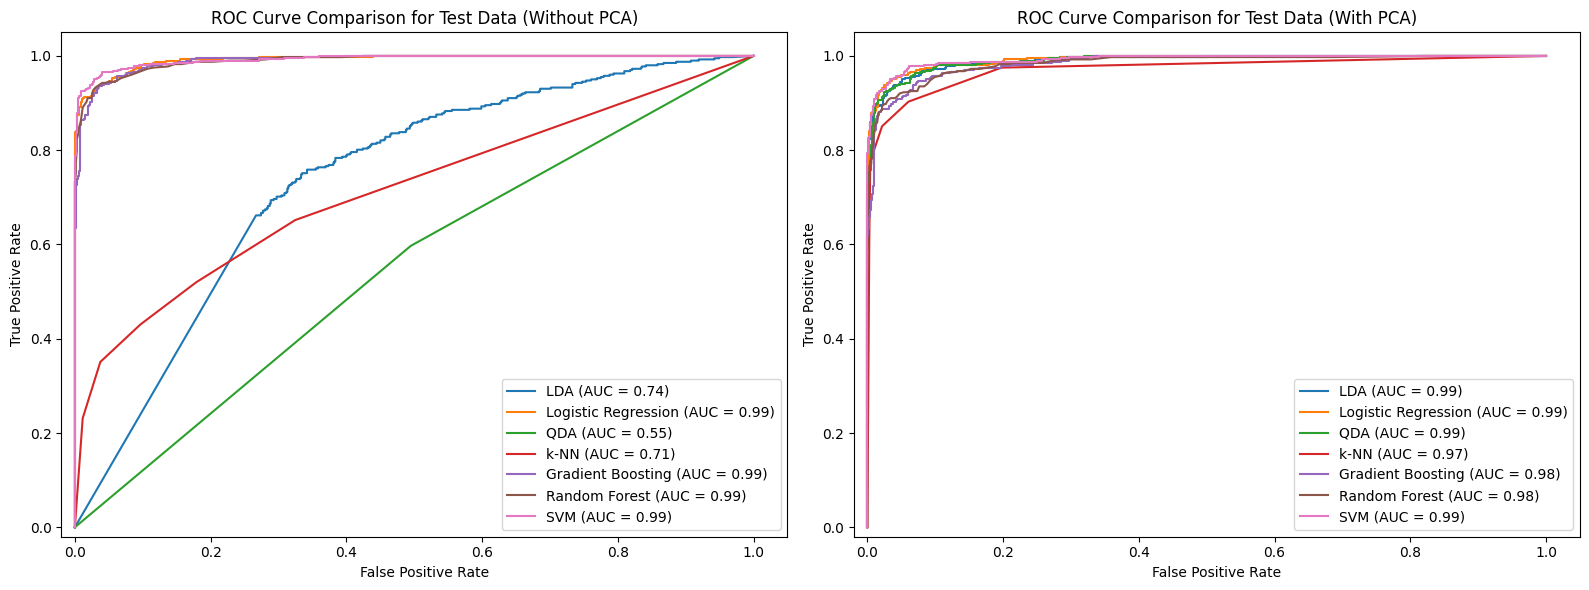

In [ ]:
# ROC curve plots for without and with PCA classifiers
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Without PCA Classifiers
for name, metrics in all_metrics.items():
    test_metrics = metrics["Test Metrics"]
    fpr, tpr, _ = test_metrics["ROC Curve"]
    ax[0].plot(fpr, tpr, label=f"{name} (AUC = {test_metrics['AUC']:.2f})")

# With PCA Classifiers
for name, metrics in all_metrics_PCA.items():
    test_metrics = metrics["Test Metrics"]
    fpr, tpr, _ = test_metrics["ROC Curve"]
    ax[1].plot(fpr, tpr, label=f"{name} (AUC = {test_metrics['AUC']:.2f})")

# Set titles, labels, and limits for both subplots
ax[0].set_title("ROC Curve Comparison for Test Data (Without PCA)")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_xlim(-0.02, 1.05)
ax[0].set_ylim(-0.02, 1.05)
ax[0].legend(loc="lower right")  # Legend in the bottom-right corner

ax[1].set_title("ROC Curve Comparison for Test Data (With PCA)")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_xlim(-0.02, 1.05)
ax[1].set_ylim(-0.02, 1.05)
ax[1].legend(loc="lower right")  # Legend in the bottom-right corner

plt.tight_layout()
plt.show()

3. Confusion Matrices

In [ ]:
# Get the confusion matrices data frames and print them
test_cm_df = get_confusion_matrices(all_metrics, "Test Metrics")
test_cm_pca_df = get_confusion_matrices(all_metrics_PCA, "Test Metrics")

print("Confusion matrices for test set (without PCA): \n", test_cm_df)
print("\nConfusion matrices for test set (with PCA): \n", test_cm_pca_df)

Confusion matrices for test set (without PCA): 
             Classifier   TN   FP   FN   TP
0                  LDA  485  208  120  282
1  Logistic Regression  667   26   25  377
2                  QDA  350  343  162  240
3                 k-NN  626   67  229  173
4    Gradient Boosting  679   14   42  360
5        Random Forest  687    6   56  346
6                  SVM  689    4   35  367

Confusion matrices for test set (with PCA): 
             Classifier   TN  FP  FN   TP
0                  LDA  690   3  59  343
1  Logistic Regression  677  16  27  375
2                  QDA  676  17  34  368
3                 k-NN  678  15  60  342
4    Gradient Boosting  674  19  45  357
5        Random Forest  674  19  41  361
6                  SVM  681  12  31  371


### Hyperparameter Tuning

In [ ]:
# Stratified K-Fold Cross Validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define classifiers
classifiers_tuning = {
    "Logistic Regression": LogisticRegression(),
    "LDA": LDA(),
    "QDA": QDA(),
    "k-NN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
}

# Define parameter grids
param_grids = {
    "Logistic Regression": {
        "solver": ["newton-cg", "lbfgs", "liblinear"],
        "C": [0.1, 1, 10, 100],
        "max_iter": [250, 500, 1000],
    },
    "LDA": {
        "solver": ["svd", "lsqr", "eigen"],
        "shrinkage": np.arange(0, 1.1, 0.1),
    },
    "QDA": {
        "reg_param": [0.0, 0.1, 0.2, 0.5, 1.0],
    },
    "k-NN": {
        "n_neighbors": range(1, 21, 2),
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200, 400],
        #"max_features": range(0, 10, 2),
        "max_features": ["sqrt", "log2"],
        "max_depth": [10, 20, 50],
    },
    "Gradient Boosting": {
        #"max_features": range(0, 10, 2),
        "max_features": ["sqrt", "log2"],
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.001, 0.01, 0.1],
        "max_depth": [3, 5, 7],
    },
    "SVM": {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "gamma": ["scale"],
        "degree": [2, 3, 4],
    },
}

Performing GridSearchCV

In [ ]:
# Define GridSearchCV function
def hyperparam_tuning(X_train, y_train):
    best_models = {}
    for name, clf in classifiers_tuning.items():
        print(f"Running GridSearchCV for {name}...")

        # Start time for tuning
        start_time = time.time()

        grid_search = GridSearchCV(
            estimator=clf,
            param_grid=param_grids[name],
            scoring="f1",
            cv=cv_strategy,
            n_jobs=-1,
            verbose=1,
        )
        grid_search.fit(X_train, y_train)
        best_models[name] = {"best_params": grid_search.best_params_, "best_score": grid_search.best_score_}

        # End time for tuning
        end_time = time.time()
        time_taken = end_time - start_time

        print(f"Time taken for {name}: {time_taken:.2f} seconds\n")
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Best CV score for {name}: {grid_search.best_score_}\n")

    return best_models

Results from Hyperparameter Tuning with GridSearchCV

In [ ]:
# Perform GridSearchCV for non-PCA data
best_hyperparams = hyperparam_tuning(X_train, y_train)

print("Best Hyperparameters for models without PCA: \n")
for name, results in best_hyperparams.items():
  print(f"{name} - Best Params: {results['best_params']}, Best Score: {results['best_score']}")

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Time taken for Logistic Regression: 535.87 seconds

Best parameters for Logistic Regression: {'C': 10, 'max_iter': 250, 'solver': 'newton-cg'}
Best CV score for Logistic Regression: 0.9394680043488048

Running GridSearchCV for LDA...
Fitting 5 folds for each of 33 candidates, totalling 165 fits


/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 165.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/discriminan

Time taken for LDA: 3436.02 seconds

Best parameters for LDA: {'shrinkage': 0.8, 'solver': 'lsqr'}
Best CV score for LDA: 0.9333997011491361

Running GridSearchCV for QDA...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  war

Time taken for QDA: 615.54 seconds

Best parameters for QDA: {'reg_param': 0.1}
Best CV score for QDA: 0.5626537470013229

Running GridSearchCV for k-NN...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Time taken for k-NN: 786.54 seconds

Best parameters for k-NN: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Best CV score for k-NN: 0.5424207228183404

Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Time taken for Random Forest: 507.34 seconds

Best parameters for Random Forest: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 400}
Best CV score for Random Forest: 0.9128460220844387

Running GridSearchCV for Gradient Boosting...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Time taken for Gradient Boosting: 518.92 seconds

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
Best CV score for Gradient Bo

In [ ]:
# Perform GridSearchCV for PCA data
best_hyperparams_PCA = hyperparam_tuning(X_train_pca, y_train)

print("Best Hyperparameters for models with PCA: \n")
for name, results in best_hyperparams_PCA.items():
  print(f"{name} - Best Params: {results['best_params']}, Best Score: {results['best_score']}")

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Time taken for Logistic Regression: 3.82 seconds

Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 250, 'solver': 'liblinear'}
Best CV score for Logistic Regression: 0.9339469991556981

Running GridSearchCV for LDA...
Fitting 5 folds for each of 33 candidates, totalling 165 fits


/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
55 fits failed out of a total of 165.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/discriminan

Time taken for LDA: 0.38 seconds

Best parameters for LDA: {'shrinkage': 0.0, 'solver': 'lsqr'}
Best CV score for LDA: 0.909757144409706

Running GridSearchCV for QDA...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Time taken for QDA: 0.09 seconds

Best parameters for QDA: {'reg_param': 0.2}
Best CV score for QDA: 0.9262323572937522

Running GridSearchCV for k-NN...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Time taken for k-NN: 4.43 seconds

Best parameters for k-NN: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best CV score for k-NN: 0.9056886687438537

Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  

Time taken for Random Forest: 203.18 seconds

Best parameters for Random Forest: {'max_depth': 50, 'max_features': 2, 'n_estimators': 200}
Best CV score for Random Forest: 0.9158537410502012

Running GridSearchCV for Gradient Boosting...
Fitting 5 folds for each of 135 candidates, totalling 675 fits


/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
135 fits failed out of a total of 675.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
93 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/st445/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
 

Time taken for Gradient Boosting: 270.60 seconds

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 4, 'n_estimators': 200}
Best CV score for Gradient Boosting: 0.9246456033822087

Running GridSearchCV for SVM...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Time taken for SVM: 119.75 seconds

Best parameters for SVM: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score for SVM: 0.9355511136652025

Best Hyperparameters for models with PCA: 

Logistic Regression - Best Params: {'C': 0.1, 'max_iter': 250, 'solver': 'liblinear'}, Best Score: 0.9339469991556981
LDA - Best Params: {'shrinkage': 0.0, 'solver': 'lsqr'}, Best Score: 0.909757144409706
QDA - Best Params: {'reg_param': 0.2}, Best Score: 0.9262323572937522
k-NN - Best Params: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}, Best Score: 0.9056886687438537
Random Forest - Best Params: {'max_depth': 50, 'max_features': 2, 'n_estimators': 20

### Training of Classifiers after Hyperparameter Tuning
1. Without PCA
2. With PCA

In [ ]:
# Classifier list with best hyperparameters for non-PCA data
classifiers_tuned = {
    "LDA": LDA(shrinkage=0.8, solver="lsqr"),
    "Logistic Regression": LogisticRegression(C=10, max_iter=250, solver="newton-cg", random_state=42),
    "QDA": QDA(reg_param=0.1),
    "k-NN": KNeighborsClassifier(metric="euclidean", n_neighbors=9, weights="uniform"),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.1, max_depth=5,
                                                    max_features="sqrt", n_estimators=200, random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=20, max_features="sqrt", n_estimators=400, random_state=42),
    "SVM": SVC(probability=True, random_state=42, C=10, degree=2, gamma="scale", kernel="rbf"),
}

# Classifier list with best hyperparameters for PCA data
classifiers_tuned_PCA = {
    "LDA": LDA(shrinkage=0.0, solver= "lsqr"),
    "Logistic Regression": LogisticRegression(C=0.1, max_iter=250, solver="liblinear", random_state=42),
    "QDA": QDA(reg_param=0.2),
    "k-NN": KNeighborsClassifier(metric="euclidean", n_neighbors=5, weights="distance"),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.1, max_depth=3,
                                                    max_features=4, n_estimators=200, random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=50, max_features=2, n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, random_state=42, C=1, degree=2, gamma="scale", kernel="rbf"),
}

all_metrics_tuned = {}
all_metrics_PCA_tuned = {}

# Run the predictions of the tuned models for two cases: without PCA and with PCA
for name, clf in classifiers_tuned.items():
    print(f"Training and evaluating {name} (without PCA):")
    results = train_and_evaluate(name, clf, X_train, X_test, y_train, y_test)
    all_metrics_tuned[name] = {"Train Metrics": results["Train Metrics"], "Test Metrics": results["Test Metrics"]}

for name, clf in classifiers_tuned_PCA.items():
    print(f"Training and evaluating tuned {name} (with PCA):")
    results_PCA = train_and_evaluate(name, clf, X_train_pca, X_test_pca, y_train, y_test)
    all_metrics_PCA_tuned[name] = {"Train Metrics": results_PCA["Train Metrics"], "Test Metrics": results_PCA["Test Metrics"]}

Training and evaluating LDA (without PCA):
--- Train Metrics for LDA ---
Accuracy: 0.98
Balanced Accuracy: 0.98
F1 Score: 0.98
AUC: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2663
           1       0.99      0.96      0.98      1713

    accuracy                           0.98      4376
   macro avg       0.98      0.98      0.98      4376
weighted avg       0.98      0.98      0.98      4376

Confusion Matrix:
[[2652   11]
 [  67 1646]]
----------------------------------------
--- Test Metrics for LDA ---
Accuracy: 0.97
Balanced Accuracy: 0.96
F1 Score: 0.95
AUC: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       693
           1       0.98      0.92      0.95       402

    accuracy                           0.97      1095
   macro avg       0.97      0.96      0.96      1095
weighted avg       0.97      0.97      

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


--- Train Metrics for QDA ---
Accuracy: 0.39
Balanced Accuracy: 0.49
F1 Score: 0.55
AUC: 0.52
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.03      0.06      2663
           1       0.39      0.96      0.55      1713

    accuracy                           0.39      4376
   macro avg       0.45      0.49      0.30      4376
weighted avg       0.46      0.39      0.25      4376

Confusion Matrix:
[[  79 2584]
 [  76 1637]]
----------------------------------------
--- Test Metrics for QDA ---
Accuracy: 0.37
Balanced Accuracy: 0.50
F1 Score: 0.54
AUC: 0.50
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       693
           1       0.37      1.00      0.54       402

    accuracy                           0.37      1095
   macro avg       0.18      0.50      0.27      1095
weighted avg       0.13      0.37      0.20      1095

Confusion Matrix:
[[  0 693

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- Train Metrics for k-NN ---
Accuracy: 0.75
Balanced Accuracy: 0.70
F1 Score: 0.59
AUC: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.94      0.82      2663
           1       0.82      0.46      0.59      1713

    accuracy                           0.75      4376
   macro avg       0.77      0.70      0.70      4376
weighted avg       0.76      0.75      0.73      4376

Confusion Matrix:
[[2490  173]
 [ 932  781]]
----------------------------------------
--- Test Metrics for k-NN ---
Accuracy: 0.73
Balanced Accuracy: 0.67
F1 Score: 0.53
AUC: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81       693
           1       0.75      0.42      0.53       402

    accuracy                           0.73      1095
   macro avg       0.74      0.67      0.67      1095
weighted avg       0.74      0.73      0.71      1095

Confusion Matrix:
[[637  

### Evaluation of Classifiers (With Hyperparameter Tuning)

1. Performance Metrics for Test Set (Tuned Model)

In [ ]:
# Compare performance metrics on the test set: with/without PCA and with/without hyperparam tuning
test_performance_df = get_performance_df(all_metrics, "Test Metrics")
test_performance_PCA_df = get_performance_df(all_metrics_PCA, "Test Metrics")
test_performance_tuned_df = get_performance_df(all_metrics_tuned, "Test Metrics")
test_performance_PCA_tuned_df = get_performance_df(all_metrics_PCA_tuned, "Test Metrics")

print("\nTest metrics (without PCA): \n", test_performance_df)
print("\nTest metrics (with PCA): \n", test_performance_PCA_df)
print("\nTest metrics for tuned models (without PCA): \n", test_performance_tuned_df)
print("\nTest metrics for tuned models (with PCA): \n", test_performance_PCA_tuned_df)


Test metrics (without PCA): 
                      Accuracy  Balanced Accuracy  F1 score    AUC
LDA                     0.700              0.701     0.632  0.739
Logistic Regression     0.953              0.950     0.937  0.992
QDA                     0.539              0.551     0.487  0.551
k-NN                    0.730              0.667     0.539  0.714
Gradient Boosting       0.949              0.938     0.928  0.990
Random Forest           0.943              0.926     0.918  0.990
SVM                     0.964              0.954     0.950  0.993

Test metrics (with PCA): 
                      Accuracy  Balanced Accuracy  F1 score    AUC
LDA                     0.943              0.924     0.917  0.990
Logistic Regression     0.961              0.955     0.946  0.992
QDA                     0.953              0.945     0.935  0.990
k-NN                    0.932              0.915     0.901  0.971
Gradient Boosting       0.942              0.930     0.918  0.984
Random Forest    

2. ROC Curves for the Test Set (Tuned Model)

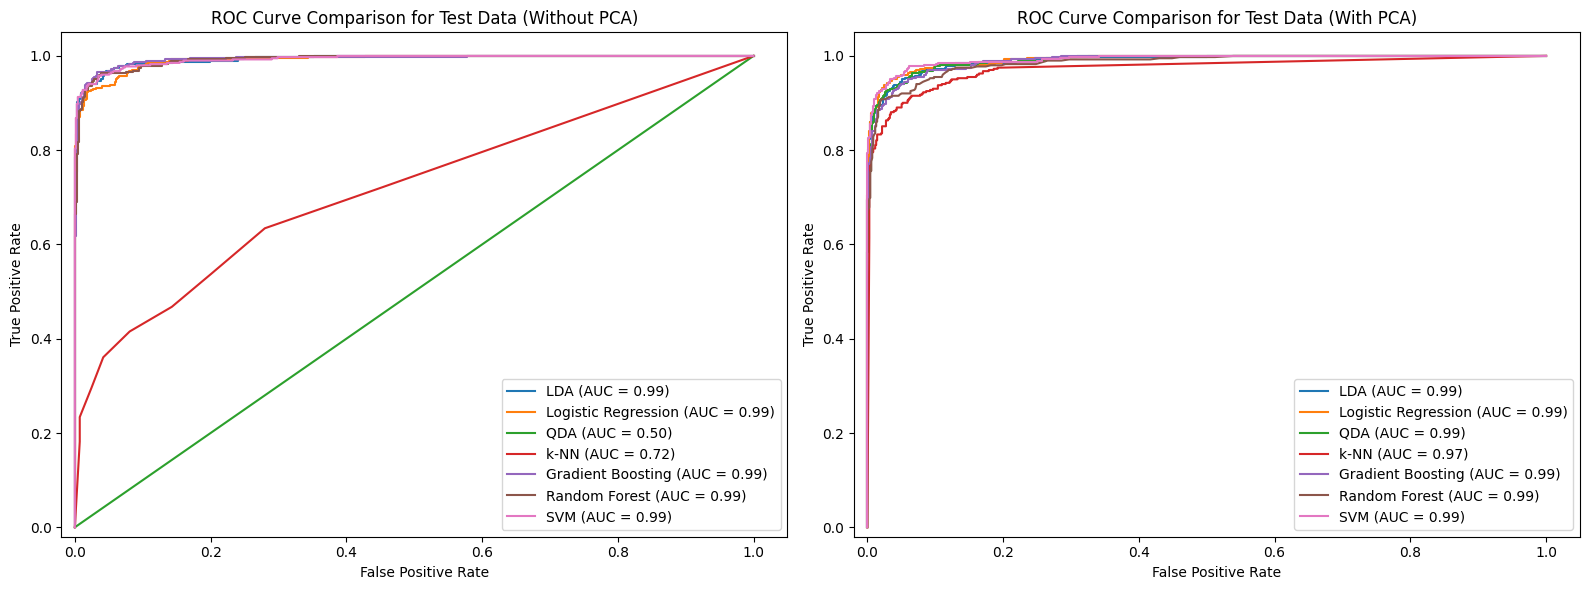

In [ ]:
# ROC curve plots for without and with PCA classifiers
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Without PCA Classifiers
for name, metrics in all_metrics_tuned.items():
    test_metrics = metrics["Test Metrics"]
    fpr, tpr, _ = test_metrics["ROC Curve"]
    ax[0].plot(fpr, tpr, label=f"{name} (AUC = {test_metrics['AUC']:.2f})")

# With PCA Classifiers
for name, metrics in all_metrics_PCA_tuned.items():
    test_metrics = metrics["Test Metrics"]
    fpr, tpr, _ = test_metrics["ROC Curve"]
    ax[1].plot(fpr, tpr, label=f"{name} (AUC = {test_metrics['AUC']:.2f})")

# Set titles, labels, and limits for both subplots
ax[0].set_title("ROC Curve Comparison for Test Data (Without PCA)")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_xlim(-0.02, 1.05)
ax[0].set_ylim(-0.02, 1.05)
ax[0].legend(loc="lower right")  # Legend in the bottom-right corner

ax[1].set_title("ROC Curve Comparison for Test Data (With PCA)")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_xlim(-0.02, 1.05)
ax[1].set_ylim(-0.02, 1.05)
ax[1].legend(loc="lower right")  # Legend in the bottom-right corner

plt.tight_layout()
plt.show()

3. Confusion Matrices (Tuned Model)

In [ ]:
# Get the confusion matrices data frames and print them
test_cm_tuned_df = get_confusion_matrices(all_metrics_tuned, "Test Metrics")
test_cm_pca_tuned_df = get_confusion_matrices(all_metrics_PCA_tuned, "Test Metrics")

print("Confusion matrices for test set (without PCA): \n", test_cm_tuned_df)
print("\nConfusion matrices for test set (with PCA): \n", test_cm_pca_tuned_df)

Confusion matrices for test set (without PCA): 
             Classifier   TN   FP   FN   TP
0                  LDA  687    6   32  370
1  Logistic Regression  670   23   27  375
2                  QDA    0  693    0  402
3                 k-NN  637   56  235  167
4    Gradient Boosting  684    9   30  372
5        Random Forest  689    4   60  342
6                  SVM  686    7   32  370

Confusion matrices for test set (with PCA): 
             Classifier   TN  FP  FN   TP
0                  LDA  690   3  59  343
1  Logistic Regression  677  16  27  375
2                  QDA  673  20  30  372
3                 k-NN  678  15  60  342
4    Gradient Boosting  671  22  37  365
5        Random Forest  680  13  41  361
6                  SVM  681  12  31  371


### T1.3 Train and evaluate three classifiers of your choice with the goal of improving the F1 score. You may use any classifier or combination of methods covered in the course including those listed in T1.2, as well as methods like bagging, boosting and regularisation.


In [ ]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

# Models for Tuned Metrics Without PCA (Regularization, Bagging, Boosting)
models_tuned_without_pca = {
    # Logistic Regression Variants
    "Logistic Regression (Regularization)": LogisticRegression(
        C=10, penalty="l2", solver="newton-cg", max_iter=250, random_state=42),
    "Logistic Regression (Bagging)": BaggingClassifier(
        estimator=LogisticRegression(C=10, solver="newton-cg", max_iter=250, random_state=42),
        n_estimators=50, random_state=42),
    "Logistic Regression (Boosting)": AdaBoostClassifier(
        estimator=LogisticRegression(C=10, solver="newton-cg", max_iter=250, random_state=42),
        n_estimators=50, learning_rate=0.1, random_state=42),

    # LDA Variants
    "LDA (Regularization)": LDA(shrinkage=0.8, solver="lsqr"),
    "LDA (Bagging)": BaggingClassifier(
        estimator=LDA(shrinkage=0.8, solver="lsqr"),
        n_estimators=50, random_state=42),

    # SVM Variants
    "SVM (Regularization)": SVC(
        C=10, kernel="rbf", degree=2, gamma="scale", probability=True, random_state=42),
    "SVM (Boosting)": AdaBoostClassifier(
        estimator=SVC(C=10, kernel="rbf", degree=2, gamma="scale", probability=True, random_state=42),
        n_estimators=50, learning_rate=0.1, random_state=42),
}

# Function to evaluate models
def evaluate_model_tuned_without_pca(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred),
    }

    print(f"\n--- {name} Results ---")
    for key, value in metrics.items():
        if key not in ["Confusion Matrix", "Classification Report"]:
            print(f"{key}: {value:.3f}")
        else:
            print(f"{key}:\n{value}")
    return metrics

# Train and evaluate all models for tuned metrics without PCA
metrics_results_tuned_without_pca = {}
for name, model in models_tuned_without_pca.items():
    print(f"Training and evaluating {name} (Tuned Metrics Without PCA)...")
    metrics_results_tuned_without_pca[name] = evaluate_model_tuned_without_pca(name, model, X_train, X_test, y_train, y_test)

# Convert results into a DataFrame for comparison
performance_df_tuned_without_pca = pd.DataFrame.from_dict(
    {
        name: {
            "Accuracy": metrics["Accuracy"],
            "Balanced Accuracy": metrics["Balanced Accuracy"],
            "F1 Score": metrics["F1 Score"],
            "AUC": metrics["AUC"] if metrics["AUC"] is not None else "N/A",
        }
        for name, metrics in metrics_results_tuned_without_pca.items()
    },
    orient="index"
)

print("\n--- Performance Metrics for Tuned Metrics Without PCA ---\n", performance_df_tuned_without_pca)

Training and evaluating Logistic Regression (Regularization) (Tuned Metrics Without PCA)...

--- Logistic Regression (Regularization) Results ---
Accuracy: 0.954
Balanced Accuracy: 0.950
F1 Score: 0.938
AUC: 0.992
Confusion Matrix:
[[670  23]
 [ 27 375]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       693
           1       0.94      0.93      0.94       402

    accuracy                           0.95      1095
   macro avg       0.95      0.95      0.95      1095
weighted avg       0.95      0.95      0.95      1095

Training and evaluating Logistic Regression (Bagging) (Tuned Metrics Without PCA)...

--- Logistic Regression (Bagging) Results ---
Accuracy: 0.960
Balanced Accuracy: 0.955
F1 Score: 0.945
AUC: 0.993
Confusion Matrix:
[[675  18]
 [ 26 376]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       693
           1       0.9

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



--- Logistic Regression (Boosting) Results ---
Accuracy: 0.963
Balanced Accuracy: 0.954
F1 Score: 0.949
AUC: 0.993
Confusion Matrix:
[[685   8]
 [ 32 370]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       693
           1       0.98      0.92      0.95       402

    accuracy                           0.96      1095
   macro avg       0.97      0.95      0.96      1095
weighted avg       0.96      0.96      0.96      1095

Training and evaluating LDA (Regularization) (Tuned Metrics Without PCA)...

--- LDA (Regularization) Results ---
Accuracy: 0.965
Balanced Accuracy: 0.956
F1 Score: 0.951
AUC: 0.993
Confusion Matrix:
[[687   6]
 [ 32 370]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       693
           1       0.98      0.92      0.95       402

    accuracy                           0.97      1095
   macro avg       0.97      

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



--- SVM (Boosting) Results ---
Accuracy: 0.948
Balanced Accuracy: 0.948
F1 Score: 0.930
AUC: 0.989
Confusion Matrix:
[[657  36]
 [ 21 381]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       693
           1       0.91      0.95      0.93       402

    accuracy                           0.95      1095
   macro avg       0.94      0.95      0.94      1095
weighted avg       0.95      0.95      0.95      1095


--- Performance Metrics for Tuned Metrics Without PCA ---
                                       Accuracy  Balanced Accuracy  F1 Score  \
Logistic Regression (Regularization)  0.954338           0.949823  0.937500   
Logistic Regression (Bagging)         0.959817           0.954675  0.944724   
Logistic Regression (Boosting)        0.963470           0.954427  0.948718   
LDA (Regularization)                  0.965297           0.955870  0.951157   
LDA (Bagging)                         0.961644        

###  T1.4 Choose the best approach among those you have tested and implement your predictor as a function in your code.

In [ ]:
def mypredict():
  df = pd.read_csv("data1.csv.gz", compression="gzip")
  df["label"] = df["label"].apply(lambda x: 1 if x == "TREG" else 0)
  X = df.drop("label", axis=1)
  y = df["label"]

  test_data = pd.read_csv("test.csv.gz", compression="gzip")
  test_data["label"] = test_data["label"].apply(lambda x: 1 if x == "TREG" else 0)
  X_test = test_data.drop("label", axis=1)
  y_test = test_data["label"]

  # Model
  lda_model = LDA(solver="lsqr", shrinkage=0.8)
  lda_model.fit(X, y)
  predictions = lda_model.predict(X_test)
  relabelled_predictions = np.where(predictions == 1, "TREG", "CD4+T")
  with open("predictions.txt", "w") as file:
        for prediction in relabelled_predictions:
            file.write(f"{prediction}\n")

  return "Output saved to predictions.txt"